In [1]:
# two

In [2]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [3]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [4]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [5]:
# optimizer
ga = GA(
    dict(
        m = 200,
        x_rate = [0.5, 1.0],
        m_rate = [0.5, 1.0],
        weight_constraint = [-3.,3.],
        radioactive_rating = [0.1, 0.5],
        grow_factor = [0.1, 0.5],
        scale_hyperparameter = False,
        regularizer = None))

In [6]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = ga, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy', 'precision', 'recall', 'f1'])

building layer 1 with 5
24
building layer 2 with 4
15


In [7]:
# data loading
DATA = os.path.join('c:\\Users\\AI-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [8]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [9]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint

    model.optimizer.rr = model.optimizer.radioactive_rating[1] - (model.optimizer.radioactive_rating[1] - model.optimizer.radioactive_rating[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.gf = model.optimizer.grow_factor[1] - (model.optimizer.grow_factor[1] - model.optimizer.grow_factor[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.crossover_rate = model.optimizer.x_rate[1] - (model.optimizer.x_rate[1] - model.optimizer.x_rate[0]) / EPOCHS * (EPOCHS - itr)
    model.optimizer.mutation_rate = model.optimizer.m_rate[0] + (model.optimizer.m_rate[1] - model.optimizer.m_rate[0]) / EPOCHS * (EPOCHS - itr)

C:\Users\AI-lab\github_repo\neural-network\python\ga.py:197: RuntimeWarning: overflow encountered in add
  self.population.sort(key=lambda p: p.fitness + np.random.uniform(-shift, shift, 1), reverse = self.aim)


Checkpoint 100, Accuracy: 0.9753086419753086, Loss: 0.14466397850601762
Checkpoint 200, Accuracy: 0.9691358024691358, Loss: 0.123299448578446
Checkpoint 300, Accuracy: 0.9753086419753086, Loss: 0.1058194637298584
Checkpoint 400, Accuracy: 0.9629629629629629, Loss: 0.12232685972143102
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.11655140806127477


In [10]:
print(history)

[{'accuracy': 0.8317757009345794, 'mean_square_error': 2.8382517740620377, 'categorical_crossentropy': 0.7488861797011901, 'precision': 0.7476635514018691, 'recall': 0.7476635514018691, 'f1': 0.7476635514018691, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 18, 'tn_hit': 17, 'fn_hit': 2}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 88, 'fn_hit': 19}, 2: {'tp_hit': 10, 'fp_hit': 9, 'tn_hit': 82, 'fn_hit': 6}}}, {'accuracy': 0.8317757009345794, 'mean_square_error': 2.8382517740620377, 'categorical_crossentropy': 0.7488861797011901, 'precision': 0.7476635514018691, 'recall': 0.7476635514018691, 'f1': 0.7476635514018691, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 18, 'tn_hit': 17, 'fn_hit': 2}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 88, 'fn_hit': 19}, 2: {'tp_hit': 10, 'fp_hit': 9, 'tn_hit': 82, 'fn_hit': 6}}}, {'accuracy': 0.8317757009345794, 'mean_square_error': 2.8382517740620377, 'categorical_crossentropy': 0.7488861797011901, 'precision': 0.7476635514018691, 'recall': 0.747663

In [11]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

In [12]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [13]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.99767846 0.00103099 0.00129053]
[0. 1. 0.] <-> [1.1359809e-02 9.8815817e-01 4.8200056e-04]
[1. 0. 0.] <-> [0.99141437 0.00147122 0.00711448]
[0. 0. 1.] <-> [9.1641143e-02 3.8598152e-04 9.0797287e-01]
[0. 1. 0.] <-> [2.6201233e-02 9.7293991e-01 8.5882150e-04]
[1. 0. 0.] <-> [0.99636024 0.00104857 0.00259116]
[1. 0. 0.] <-> [0.87417865 0.12064847 0.00517291]
[1. 0. 0.] <-> [9.9729025e-01 7.1913714e-04 1.9906894e-03]
[1. 0. 0.] <-> [0.9749501  0.00876932 0.01628063]
[1. 0. 0.] <-> [0.9616384  0.03459382 0.00376782]
[1. 0. 0.] <-> [9.9693871e-01 6.7711633e-04 2.3841907e-03]
[0. 1. 0.] <-> [1.1308349e-02 9.8820633e-01 4.8532605e-04]
[1. 0. 0.] <-> [0.9956714  0.00217992 0.00214869]
[0. 1. 0.] <-> [2.4118502e-02 9.7508574e-01 7.9580682e-04]
[1. 0. 0.] <-> [0.99378794 0.00317154 0.00304054]
[1. 0. 0.] <-> [9.9752301e-01 9.3180640e-04 1.5451985e-03]
[0. 0. 1.] <-> [3.9155795e-03 3.6120147e-04 9.9572325e-01]
[0. 0. 1.] <-> [8.4891496e-03 1.5618315e-04 9.9135464e-01]
[0. 1. 0.]

In [14]:
# Testing Performance

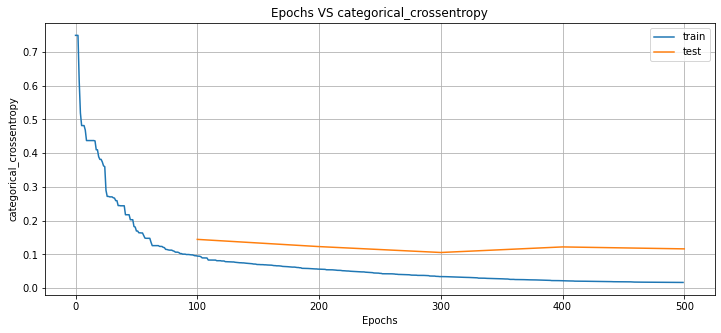

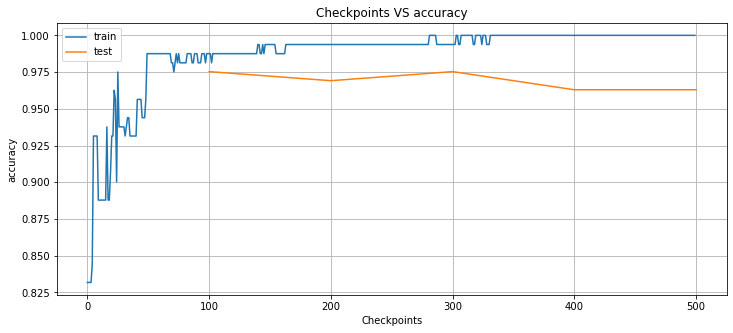

In [15]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [16]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9753086419753086, 'mean_square_error': 0.06961613017890375, 'categorical_crossentropy': 0.14466397850601762, 'precision': 0.9629629629629629, 'recall': 0.9629629629629629, 'f1': 0.9629629629629629, 'essential_metrics': {0: {'tp_hit': 77, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 1}, 1: {'tp_hit': 15, 'fp_hit': 1, 'tn_hit': 91, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9691358024691358, 'mean_square_error': 0.06248828721638122, 'categorical_crossentropy': 0.123299448578446, 'precision': 0.9537037037037037, 'recall': 0.9537037037037037, 'f1': 0.9537037037037037, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 3, 'tn_hit': 27, 'fn_hit': 2}, 1: {'tp_hit': 15, 'fp_hit': 2, 'tn_hit': 90, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 0, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 200} 


{'accuracy': 0.9753086419753086, 'mean_square_error': 0.056615466120529666, 'categorical_crossentropy': 0.1058194637298584, 'precisi

In [17]:
print(model)

Layer 1
Neuron 0: weights:
[ 2.0685375  -3.         -2.9639707   0.47561926 -1.236958  ]
 bias: 1.6012325286865234

Neuron 1: weights:
[-0.42069462  3.          1.6672887  -1.0587728  -3.        ]
 bias: 2.7835001945495605

Neuron 2: weights:
[ 2.1530223  -3.         -3.          0.639556    0.32107607]
 bias: 2.325829267501831

Neuron 3: weights:
[-0.4125209 -3.         1.2207974  2.6542056  3.       ]
 bias: -1.8056204319000244

$
Layer 2
Neuron 0: weights:
[ 3.        2.720076  3.       -3.      ]
 bias: -1.1857717037200928

Neuron 1: weights:
[-3.        3.       -3.        0.818595]
 bias: 3.0

Neuron 2: weights:
[ 0.09990024 -2.9927728   2.1074972   3.        ]
 bias: 1.367081880569458

$

